In [1]:
import requests
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np 
import random
from tqdm import tqdm_notebook
import folium 
from geopy.geocoders import Nominatim
import urllib.request
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


#from IPython.display import Image 
#from IPython.core.display import HTML 
#from pandas.io.json import json_normalize


**The Battle of Neighborhoods**

This notebook is part 1 of the submissions for the final capstone project in the IBM Data Science Professional Certificate course on Coursera.

**Preamble**

Mr. Nolan is going to be moving in to the city of Chennai, located at the edge part of the Indian subcontinent. He needs to find suitable housing. However, he frets. He doesn't worry about the locality one bit; except the fulfillment of one condition: there needs to be a lot of restaurants/food stalls nearby. You see, Mr. Nolan is a foodie. Not a day goes by where he does not make or savour a new dish. He has come to me for help, asking me to analyze the different areas in the city of Chennai and find which neighborhoods would be the best for a foodie like him to move in to.

Me, being the perfect philanthropist as I am, have decided to help Mr. Nolan using a bit of data and a bit of science.

Jokes aside, here's how I plan to do it.

**Introduction**

The aim here is to find neighborhoods with a high frequency of restaurants/food stalls/cafes. Firstly, the number of neighborhoods and their respective coordinates need to be retrieved, so that Foursquare can find nearby venues. Using this data, Foursquare should search for nearby venues and get their categories.

These venues are then clustered using k-means. The cluster in which eateries are of the highest frequency will be the set of neighborhoods we are looking for. All of these neighborhoods are suitable for Mr.Nolan to move in.

This problem can also be easily extended to fit other requests, such as finding the neighborhoods with low real estate prices, neighborhoods with a wide variety of grocery shops, neighborhoods closes to public transport systems etc.

The target audience here is people who are moving to a new city and require some knowledge about the neighborhoods beforehand so that they can decide the place they want to live in.

**Data**

**Wikipedia Scraper**

Since available data for Chennai city was sparse, I've manually scraped the list of neighborhoods from this Wikipedia page using bs4, and then grabbed all the hyperlinks. Using urllib, these links are visited individually and the coordinates and pincodes (neighborhoods identifiers) are scraped and put into a pandas dataframe.

In [2]:
url = 'https://en.wikipedia.org/wiki/Areas_of_Chennai'
page_unparsed = urllib.request.urlopen(url)
soup = BeautifulSoup(page_unparsed, 'html.parser')

In [3]:
wiki_rows = [] # each row in the wikipedia table
urls = []
names = []

wiki_table = soup.find_all("table", {"class": "wikitable"})
for row in wiki_table:
  wiki_rows.append(row.find_all('a', href=True))

# gets names and links of each neighborhood so that further scraping can be done
for i in range(len(wiki_rows[0])):
  urls.append('https://en.wikipedia.org' + wiki_rows[0][i]['href'])
  names.append(wiki_rows[0][i].text)

In [4]:
# getting data from each neighborhood

latitudes = []
longitudes = []
pincodes = []

for url in tqdm_notebook(urls, total = len(urls), unit = 'url'):
  try: # because some links are broken
    page_unparsed = urllib.request.urlopen(url)
    soup = BeautifulSoup(page_unparsed, 'html.parser')
  except:
    continue

  coords = soup.find("span", {"class" : "geo-dec"})
  pincode = soup.find("div", {"class" : "postal-code"})

  if coords == None:  # because some pages do not have coordinates listed
    latitudes.append(np.nan)
    longitudes.append(np.nan)

  else:
    coords = coords.text.split()
    latitudes.append(float(coords[0].replace('N', '').replace('°', '')))
    longitudes.append(float(coords[1].replace('E', '').replace('°', '')))

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [5]:
neighborhoods = pd.DataFrame(list(zip(names, latitudes, longitudes)), columns =['Name', 'Latitude', 'Longitude']) 
neighborhoods = neighborhoods[neighborhoods['Latitude'].notnull()]
neighborhoods = neighborhoods[neighborhoods['Longitude'].notnull()]
neighborhoods.head()

,Name,Latitude,Longitude
0,Adambakkam,12.9900,80.2000
1,Adyar,13.0063,80.2574
2,Alandur,13.0030,80.2040
3,Alapakkam,13.0490,80.1673
4,Alwarpet,13.0339,80.2486


**Foursquare**

Using Foursquare, individual neighboords are searched to find nearby venues and their categories withing a 500m radius of a randomnly chosen neighborhood, Choolaimedu.

In [6]:
CLIENT_ID = 'BEYJXL240KTU54SBM4YR1FGO2LSOQ5LVFBRAYFW5YNP4YFI0' # your Foursquare ID
CLIENT_SECRET = 'XOEBQ2HUD5KVGZVLD1ETXN45MF4NQN1XBAJ0FNN4R1VZA5D0' # your Foursquare Secret
VERSION = '20190130'

In [9]:
neighborhood_latitude = neighborhoods[neighborhoods['Name'] == 'Choolaimedu']['Latitude']
neighborhood_longitude = neighborhoods[neighborhoods['Name'] == 'Choolaimedu']['Longitude']
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID[::-1], 
    CLIENT_SECRET[::-1], 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # 

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    for name, lat, lng in tqdm_notebook(zip(names, latitudes, longitudes), total = neighborhoods.shape[0], unit = 'neighborhoods'):
        # print(name)

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID[::-1], 
            CLIENT_SECRET[::-1], 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
chennai_venues = getNearbyVenues(names = neighborhoods['Name'],
                                   latitudes = neighborhoods['Latitude'],
                                   longitudes = neighborhoods['Longitude'])
chennai_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Adambakkam,12.9900,80.2000,Pizza Republic,4bf58dd8d48988d1ca941735,12.990987,80.198613,Pizza Place
1,Adambakkam,12.9900,80.2000,Loiee,4bf58dd8d48988d16a941735,12.992197,80.199000,Bakery
2,Adambakkam,12.9900,80.2000,Thalapakattu Hotel,4bf58dd8d48988d142941735,12.991979,80.198937,Asian Restaurant
3,Adambakkam,12.9900,80.2000,Fun City,4bf58dd8d48988d18d941735,12.993955,80.198047,Gaming Cafe
4,Adyar,13.0063,80.2574,Bombay Brassiere,54135bf5e4b08f3d2429dfdd,13.006961,80.256419,North Indian Restaurant


In [13]:
chennai_onehot = pd.get_dummies(chennai_venues[['Venue Category']], prefix="", prefix_sep="")
chennai_onehot['Neighborhood'] = chennai_venues['Neighborhood'] 
fixed_columns = [chennai_onehot.columns[-1]] + list(chennai_onehot.columns[:-1])
chennai_onehot = chennai_onehot[fixed_columns]
chennai_onehot.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,Airport Gate,Airport Lounge,American Restaurant,Antique Shop,Arcade,...,Theme Park,Tourist Information Center,Toy / Game Store,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adyar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
chennai_grouped

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,Airport Gate,Airport Lounge,American Restaurant,Antique Shop,Arcade,...,Theme Park,Tourist Information Center,Toy / Game Store,Train,Train Station,Travel & Transport,Vegetarian / Vegan Restaurant,Warehouse Store,Women's Store,Yoga Studio
0,Adambakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.0
1,Adyar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.03125,0.000000,0.00000,0.0
2,Alandur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.0
3,Alapakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.0
4,Alwarpet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,United India Colony,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.500000,0.0,0.00000,0.000000,0.00000,0.0
132,Vadapalani,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.333333,0.0,0.00000,0.000000,0.00000,0.0
133,Valasaravakkam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.142857,0.00000,0.0
134,Vallalar Nagar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.03125,0.000000,0.03125,0.0


In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Gaming Cafe,Pizza Place,Bakery,Asian Restaurant,Yoga Studio,Food & Drink Shop,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service
1,Adyar,Indian Restaurant,Electronics Store,Juice Bar,North Indian Restaurant,Italian Restaurant,Grocery Store,Fast Food Restaurant,Coffee Shop,Rock Club,Café
2,Alandur,Fast Food Restaurant,Indian Restaurant,Hotel Bar,Hotel,Yoga Studio,Fruit & Vegetable Store,Food Stand,Food Service,Food Court,Food & Drink Shop
3,Alapakkam,Fast Food Restaurant,Indian Restaurant,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service,Food Court,Food & Drink Shop,Food
4,Alwarpet,Japanese Restaurant,Indian Restaurant,Lounge,Italian Restaurant,Restaurant,Hotel,Thai Restaurant,Men's Store,Nightclub,Chinese Restaurant


In [16]:
# set number of clusters
kclusters = 4

chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chennai_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')

chennai_merged.head() # check the last columns!

,Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,12.9900,80.2000,1.0,Gaming Cafe,Pizza Place,Bakery,Asian Restaurant,Yoga Studio,Food & Drink Shop,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service
1,Adyar,13.0063,80.2574,1.0,Indian Restaurant,Electronics Store,Juice Bar,North Indian Restaurant,Italian Restaurant,Grocery Store,Fast Food Restaurant,Coffee Shop,Rock Club,Café
2,Alandur,13.0030,80.2040,3.0,Fast Food Restaurant,Indian Restaurant,Hotel Bar,Hotel,Yoga Studio,Fruit & Vegetable Store,Food Stand,Food Service,Food Court,Food & Drink Shop
3,Alapakkam,13.0490,80.1673,3.0,Fast Food Restaurant,Indian Restaurant,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service,Food Court,Food & Drink Shop,Food
4,Alwarpet,13.0339,80.2486,1.0,Japanese Restaurant,Indian Restaurant,Lounge,Italian Restaurant,Restaurant,Hotel,Thai Restaurant,Men's Store,Nightclub,Chinese Restaurant


In [17]:
chennai_merged = chennai_merged[chennai_merged['Cluster Labels'].notnull()]

# create map
map_clusters = folium.Map(location=[13.067439, 80.237617], zoom_start=11)

# set color scheme for the clusters
'''
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.hsv(np.linspace(0, 1, len(ys)))
hsv = [colors.rgb2hex(i) for i in colors_array]
'''

colors = ["#ff0000", "#3d84ad", "#000000", "#ffff00"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Name'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[int(cluster)],
        fill=True,
        fill_color=colors[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       

map_clusters

In [18]:

chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]['1st Most Common Venue'].value_counts().head()

Train Station    5
Platform         4
Name: 1st Most Common Venue, dtype: int64

In [19]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]['1st Most Common Venue'].value_counts().head()

Indian Restaurant    26
Pizza Place           7
Department Store      7
ATM                   5
Juice Bar             3
Name: 1st Most Common Venue, dtype: int64

In [20]:

chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Kodambakkam,ATM,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service,Food Court,Food & Drink Shop,Food,Fast Food Restaurant
66,Mandaveli,ATM,Spa,Deli / Bodega,Department Store,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service,Food Court
67,Mangadu,ATM,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service,Food Court,Food & Drink Shop,Food,Fast Food Restaurant
144,Tiruverkadu,ATM,Flower Shop,Furniture / Home Store,Fruit & Vegetable Store,Food Stand,Food Service,Food Court,Food & Drink Shop,Food,Fast Food Restaurant


In [21]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]['1st Most Common Venue'].value_counts().head()

Fast Food Restaurant    7
Theater                 1
Dessert Shop            1
Deli / Bodega           1
Name: 1st Most Common Venue, dtype: int64

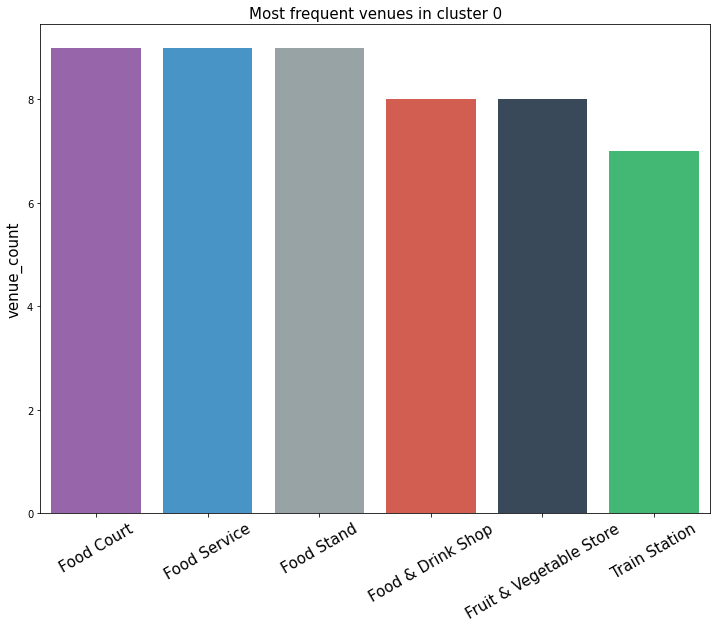

In [22]:
clus1 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 0].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig, ax = plt.subplots(figsize=(12, 9))
ax = sns.barplot(x = clus1.index, y = clus1['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30,  fontsize = 15)
ax.yaxis.label.set_size(15)
plt.title('Most frequent venues in cluster 0', fontsize = 15)
plt.show()

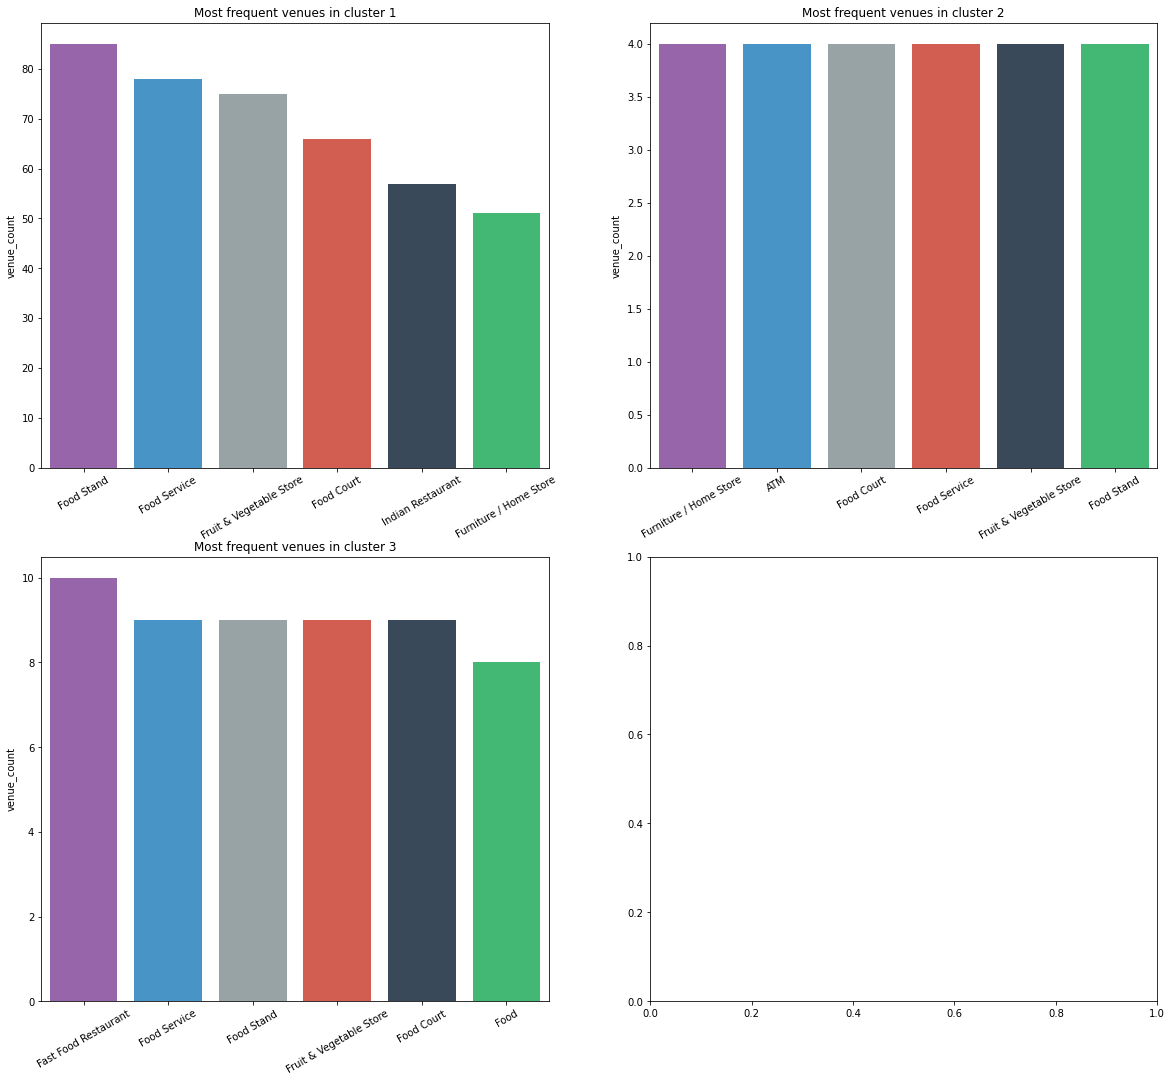

In [24]:
clus1 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 1].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])
clus2 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 2].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])
clus3 = pd.DataFrame(pd.DataFrame(list(chennai_merged[chennai_merged['Cluster Labels'] == 3].iloc[:, 4:15].values.ravel()), columns = ['venue_count'])['venue_count'].value_counts()[:6])

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig, ax = plt.subplots(2,2, figsize = (20, 18))


plt.subplot(2, 2, 1)
ax = sns.barplot(x = clus1.index, y = clus1['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most frequent venues in cluster 1')

plt.subplot(2, 2, 2)
ax = sns.barplot(x = clus2.index, y = clus2['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most frequent venues in cluster 2')

plt.subplot(2, 2, 3)
ax = sns.barplot(x = clus3.index, y = clus3['venue_count'], palette=(flatui))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most frequent venues in cluster 3', )


plt.show()

In [25]:
chennai_venues['Venue Category'].value_counts()

Indian Restaurant                131
Fast Food Restaurant              36
Vegetarian / Vegan Restaurant     31
Train Station                     30
Hotel                             27
                                ... 
Modern European Restaurant         1
Rock Club                          1
Pool                               1
Smoke Shop                         1
Bed & Breakfast                    1
Name: Venue Category, Length: 157, dtype: int64

The sheer number of restaurants probably skew the results. There might be two reaons for this:

Foursquare data predominantly contains restaurant data.
There are way too many restaurants in Chennai.
Chennai is not in any means a developed city. It contains numerous shops and stalls which simply will not be indexed or recorded by any location API like Foursquare, or even Google Maps. And multiple venues open each day, the updation of this data is also an issue. Due to these reasons, accurate analysis cannot be done.

**Conclusion**

Mr. Nolan would not have trouble finding food in the city of Chennai. For lesser travel times, he can choose any of the 58 neighborhoods in Cluster 1, however he'll find that most of them are Indian restaurants. Independent of travel distance, the cluster choice does not matter much as there are more restaurants than any other venue. There is simply not enough data to do an in-depth analysis. However, individually marking the venues which are food-related is also a possibility- something to do for the future.

The efficacy of the project was impacted by the limited effectives of the Foursquare API for a place like Chennai. Using some other city would've probably yielded better results. The way the neighborhoods were suggested were due to Indian restaurants alone. More diversity from more food stalls could've been used, i.e. Donut Shops, Bakeries, Pizzerias, etc.

Further analysis could've been done by using the rating of each venue however yet again ratings were not available for venues in Chennai. If ratings were available, individual restaurants in each locality could've been suggested.